<a href="https://colab.research.google.com/github/CatarinaNSSilva/Semana_Ciencia_UC/blob/main/codigo_atividade_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Antes de começarmos

Pode modificar este bloco de notas (notebook) diretamente e trabalhar nos exercícios, mas não te esqueças de salvar uma cópia no teu Goodle Drive (na aba _Ficheiro_ ou _File_)!

Podes usar o menu à esquerda para navegar no notebook, adicionar uma nova linha de código ou texto em “+ Code” ou “+ Text” acima.

# Extrair imagens

Para aceder às imagens para esta atividade vamos clonar aqui, no ambiente de trabalho do Google Colab, a pasta que criei no GitHub.


In [1]:
import os

git_folder = "CatarinaNSSilva/Semana_Ciencia_UC"
if os.path.exists(git_folder) == False:
   !git clone https://github.com/CatarinaNSSilva/Semana_Ciencia_UC.git

path_to_images = git_folder

Cloning into 'Semana_Ciencia_UC'...
remote: Enumerating objects: 796, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 796 (delta 4), reused 0 (delta 0), pack-reused 790
Receiving objects: 100% (796/796), 1.11 GiB | 31.25 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Updating files: 100% (184/184), done.


Esta atividade usa o [TensorFlow](https://www.tensorflow.org/resources/libraries-extensions). TensorFlow é uma plataforma para aprendizado de máquina. A plataforma possui um grande número de funções integradas.

Para executar este exemplo, primeiro precisamos instalar e importar outros pacotes necessários, incluindo o [Keras](https://keras.io/about/#:~:text=Keras%20is%20the%20high%2Dlevel,solutions%20with%20high%20iteration%20velocity.), [Numpy](https://numpy.org/) e o [Matplotlib](https://matplotlib.org/) para visualização.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Criar a dataset

In [3]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use ~80% of the images for training and 20% for validation.

É uma boa prática dovidir os nossos dados em validação (cerca de 80%) e treino  (20%) para verificar o desempenho do modelo de IA.

In [4]:
data_dir = '/content/Semana_Ciencia_UC/imagens'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 158 files belonging to 3 classes.
Using 127 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 158 files belonging to 3 classes.
Using 31 files for validation.


In [6]:
data_dir_test = '/content/Semana_Ciencia_UC/imagens_teste'

test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    shuffle=False,
    batch_size=batch_size,
    image_size=(img_height, img_width))

Found 24 files belonging to 3 classes.


In [7]:
class_names = test_dataset.class_names
print(class_names)

['cavalo-marinho', 'estrela-do-mar', 'golfinho']


## Visualizar os dados

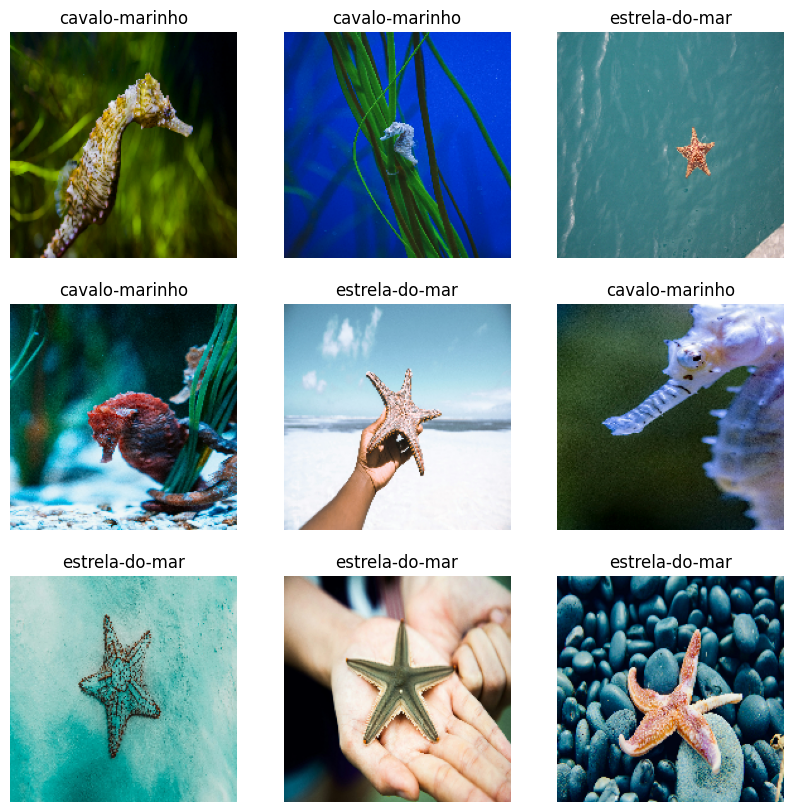

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


Agora passamos este conjunto de dados para o método Keras Model.fit, o formato necessario para treino do modelo, que faremos a serguir.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

As nossas imagens estão agora na forma de um tensor ou matriz da forma (32, 180, 180, 3). Trata-se de um lote de 32 imagens no formato 180x180x3 (a última dimensão refere-se aos canais de cores RGB).


## Padronizar os dados

Os valores do canal RGB estão entre [0, 255]. Isto não é ideal para uma rede neural (o modelo que vamos treinar); no geral, deve-se tentar diminuir os valores.

Aqui, vamos padronizar os valores para estarem no intervalo [0, 1] usando tf.keras.layers.Rescaling:

In [9]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normalized_test_ds = test_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_test_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0
0.0 1.0


# Treinar um modelo de IA

Vamos usar uma rede neuronal simples com 3 blocos:

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilar a estrutura do modelo

Podemos alterar muitas definicoes para optimizar o modelo mas vamos ficar por aqui hoje :)

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Treinar (ou ensinar) a IA

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/50
4/4 [==============================] - 39s 2s/step - loss: 2.5464 - accuracy: 0.3150 - val_loss: 1.5700 - val_accuracy: 0.1290
Epoch 2/50
4/4 [==============================] - 33s 2s/step - loss: 1.0264 - accuracy: 0.4173 - val_loss: 0.9670 - val_accuracy: 0.4194
Epoch 3/50
4/4 [==============================] - 32s 2s/step - loss: 0.8788 - accuracy: 0.4803 - val_loss: 0.9560 - val_accuracy: 0.5161
Epoch 4/50
4/4 [==============================] - 37s 3s/step - loss: 0.7524 - accuracy: 0.7087 - val_loss: 0.8058 - val_accuracy: 0.7097
Epoch 5/50
4/4 [==============================] - 37s 3s/step - loss: 0.5847 - accuracy: 0.7717 - val_loss: 0.7022 - val_accuracy: 0.7419
Epoch 6/50
4/4 [==============================] - 33s 2s/step - loss: 0.4385 - accuracy: 0.8425 - val_loss: 1.6644 - val_accuracy: 0.4194
Epoch 7/50
4/4 [==============================] - 32s 2s/step - loss: 0.4643 - accuracy: 0.7874 - val_loss: 0.6709 - val_accuracy: 0.8065
Epoch 8/50
4/4 [==================

## Visualizar os resultados

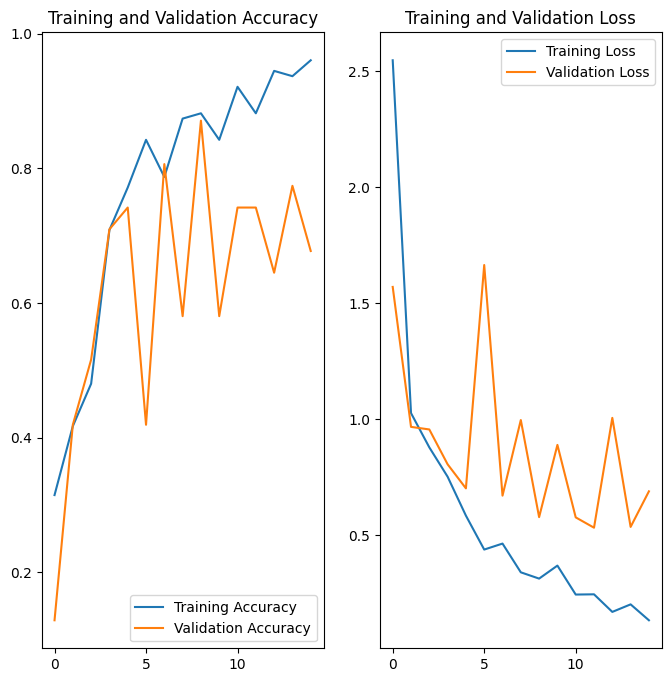

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15) # modificar o valor para o numero de épocas do treino acima

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
loss, accuracy = model.evaluate(train_ds)

4/4 [==============================] - 27s 13ms/step - loss: 0.0960 - accuracy: 0.9764


In [14]:
loss, accuracy = model.evaluate(val_ds)

1/1 [==============================] - 7s 7s/step - loss: 0.6893 - accuracy: 0.6774


## Matriz de confusão (ou matriz de erro)

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


for images, labels in test_dataset.take(1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

y_prediction = model.predict(test_dataset)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(numpy_labels, y_prediction , normalize='true')


disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=class_names)
disp.plot(cmap='Blues')
plt.grid(False)

plt.show()

1/1 [==============================] - 5s 5s/step


NameError: name 'confusion_matrix' is not defined